In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
#from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import neighbors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
from torchvision import  transforms

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from network import Net
from dataset import get_dataloaders

In [3]:
def accuracy(output, target):
  pred = output.argmax(dim=1)  # get the index of the max log-probability
  return (pred == target).sum().item() / target.numel()  #return the mean accuracy in the batch


In [4]:
def eval_epoch(model, test_loader, criterion, epoch):  #evaluation function after one epoch of training
  
    model.eval()     #eval mode
      
    with torch.no_grad():
        eval_losses = []
        eval_accs = []
        for (inputs, labels) in test_loader:
            #send to GPU device
            inputs, labels = inputs.to(device), labels.to(device)            
            #forward pass
            outputs = model(inputs)  
            #compute the loss in the batch
            eval_loss = criterion(outputs, labels)
            eval_losses.append(eval_loss.item()) #save loss value
            #compute the accuracy in the batch
            eval_acc = 100 * accuracy(outputs, labels) 
            eval_accs.append(eval_acc) #save the accuracy value 
            
        print('Val Epoch: {} \tAverage loss: {:.4f}\tAverage Acc: {:.2f} %'.format(
            epoch, np.mean(eval_losses), np.mean(eval_accs)))
        
        #val_writer.add_scalar('Loss', np.mean(eval_losses), epoch)  #log validation loss for one epoch to Tensorboard
        #val_writer.add_scalar('Acc',  np.mean(eval_accs), epoch)    #log validation accuracy for one epoch to Tensorboard

    return np.mean(eval_losses), np.mean(eval_accs)    

In [5]:
DATASETDIR = "../MIT_split/"
MODEL_FNAME = 'model.h5'
BATCH_SIZE = 32
EPOCHS = 100
INPUT_SIZE = 64


In [6]:
train_loader, test_loader,train_data,test_data = get_dataloaders(DATASETDIR, INPUT_SIZE, BATCH_SIZE)

In [8]:
### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}".format(
                    epoch, batch_idx, loss
                )
            )


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    return accuracies


device = torch.device("cuda")

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

batch_size = 256

model = Net().to(device)
########
PATH = 'model_pt/best_params.pt'
#model = models.resnet18(pretrained=True)
#model.fc = nn.Linear(512, 8)
model.load_state_dict(torch.load(PATH))
model.to(device)
cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    model.cuda()
########
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 200

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
#loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
loss_func = losses.ContrastiveLoss(pos_margin=1, neg_margin=0,  distance=distance, reducer=reducer)
mining_func = None
mining_func = miners.PairMarginMiner(
    distance=distance
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=5)
### pytorch-metric-learning stuff ###
criterion = nn.CrossEntropyLoss()   #logsoftmax layer + NLLLoss

for epoch in range(1, num_epochs + 1):
    train(model, loss_func, mining_func, device, train_loader, optimizer, epoch)
    val_acc1 = test(train_data, test_data, model, accuracy_calculator)
    #print(type(val_acc1))
    #print(val_acc1['precision_at_1'])
    best_accuracy = 0.0
    val_acc = val_acc1['precision_at_1']
    if best_accuracy < val_acc:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'model_pt' + '/best_params2.pt')  #save the model state for best val accuracy

    #val_loss, val_acc = eval_epoch(model, test_loader, criterion, epoch)  

Epoch 1 Iteration 0: Loss = 0.8608020544052124
Epoch 1 Iteration 10: Loss = 0.8502522706985474
Epoch 1 Iteration 20: Loss = 0.8365873694419861
Epoch 1 Iteration 30: Loss = 0.8305540084838867
Epoch 1 Iteration 40: Loss = 1.6472599506378174
Epoch 1 Iteration 50: Loss = 1.7081189155578613


100%|██████████| 26/26 [00:00<00:00, 53.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8413878562577447
Epoch 2 Iteration 0: Loss = 1.6832927465438843
Epoch 2 Iteration 10: Loss = 0.8456482291221619
Epoch 2 Iteration 20: Loss = 0.8741199970245361
Epoch 2 Iteration 30: Loss = 0.8320398330688477
Epoch 2 Iteration 40: Loss = 0.8995137214660645
Epoch 2 Iteration 50: Loss = 0.8630046844482422


100%|██████████| 26/26 [00:00<00:00, 56.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.838909541511772
Epoch 3 Iteration 0: Loss = 1.740483045578003
Epoch 3 Iteration 10: Loss = 0.8164945840835571
Epoch 3 Iteration 20: Loss = 0.8532185554504395
Epoch 3 Iteration 30: Loss = 0.8177072405815125
Epoch 3 Iteration 40: Loss = 0.8561083078384399
Epoch 3 Iteration 50: Loss = 0.8414020538330078


100%|██████████| 26/26 [00:00<00:00, 56.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 4 Iteration 0: Loss = 0.8378059267997742
Epoch 4 Iteration 10: Loss = 0.8473248481750488
Epoch 4 Iteration 20: Loss = 0.9350436925888062
Epoch 4 Iteration 30: Loss = 0.8500131964683533
Epoch 4 Iteration 40: Loss = 0.8657909631729126
Epoch 4 Iteration 50: Loss = 1.7013838291168213


100%|██████████| 26/26 [00:00<00:00, 63.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 5 Iteration 0: Loss = 0.9172502160072327
Epoch 5 Iteration 10: Loss = 0.8270010948181152
Epoch 5 Iteration 20: Loss = 0.8362377882003784
Epoch 5 Iteration 30: Loss = 0.8268955945968628
Epoch 5 Iteration 40: Loss = 0.8382452726364136
Epoch 5 Iteration 50: Loss = 1.6337554454803467


100%|██████████| 26/26 [00:00<00:00, 55.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 6 Iteration 0: Loss = 1.7088550329208374
Epoch 6 Iteration 10: Loss = 0.8670148849487305
Epoch 6 Iteration 20: Loss = 0.818017840385437
Epoch 6 Iteration 30: Loss = 0.8435063362121582
Epoch 6 Iteration 40: Loss = 0.8489431142807007
Epoch 6 Iteration 50: Loss = 0.8075515031814575


100%|██████████| 26/26 [00:00<00:00, 59.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 7 Iteration 0: Loss = 0.8250477313995361
Epoch 7 Iteration 10: Loss = 1.6282198429107666
Epoch 7 Iteration 20: Loss = 0.8446965217590332
Epoch 7 Iteration 30: Loss = 1.749361276626587
Epoch 7 Iteration 40: Loss = 0.844568133354187
Epoch 7 Iteration 50: Loss = 1.6454797983169556


100%|██████████| 26/26 [00:00<00:00, 56.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 8 Iteration 0: Loss = 0.8377131819725037
Epoch 8 Iteration 10: Loss = 0.8110288977622986
Epoch 8 Iteration 20: Loss = 0.8342521786689758
Epoch 8 Iteration 30: Loss = 0.8454141616821289
Epoch 8 Iteration 40: Loss = 0.0
Epoch 8 Iteration 50: Loss = 0.8419004678726196


100%|██████████| 26/26 [00:00<00:00, 60.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8525402726146221
Epoch 9 Iteration 0: Loss = 1.6168670654296875
Epoch 9 Iteration 10: Loss = 0.8463498950004578
Epoch 9 Iteration 20: Loss = 0.8572648763656616
Epoch 9 Iteration 30: Loss = 0.8620737791061401
Epoch 9 Iteration 40: Loss = 0.8447238802909851
Epoch 9 Iteration 50: Loss = 0.845262885093689


100%|██████████| 26/26 [00:00<00:00, 57.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 10 Iteration 0: Loss = 0.8756775259971619
Epoch 10 Iteration 10: Loss = 0.8609156608581543
Epoch 10 Iteration 20: Loss = 0.830653190612793
Epoch 10 Iteration 30: Loss = 0.8571123480796814
Epoch 10 Iteration 40: Loss = 1.7342926263809204
Epoch 10 Iteration 50: Loss = 1.7117401361465454


100%|██████████| 26/26 [00:00<00:00, 60.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 11 Iteration 0: Loss = 0.811145007610321
Epoch 11 Iteration 10: Loss = 0.8009283542633057
Epoch 11 Iteration 20: Loss = 0.8253642320632935
Epoch 11 Iteration 30: Loss = 0.8400733470916748
Epoch 11 Iteration 40: Loss = 1.6941392421722412
Epoch 11 Iteration 50: Loss = 0.829342782497406


100%|██████████| 26/26 [00:00<00:00, 56.82it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8351920693928129
Epoch 12 Iteration 0: Loss = 0.8150495886802673
Epoch 12 Iteration 10: Loss = 0.8506501913070679
Epoch 12 Iteration 20: Loss = 1.6954340934753418
Epoch 12 Iteration 30: Loss = 0.8627597093582153
Epoch 12 Iteration 40: Loss = 0.8058092594146729
Epoch 12 Iteration 50: Loss = 1.7652618885040283


100%|██████████| 26/26 [00:00<00:00, 62.64it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 13 Iteration 0: Loss = 1.6579896211624146
Epoch 13 Iteration 10: Loss = 1.6621966361999512
Epoch 13 Iteration 20: Loss = 0.8348438143730164
Epoch 13 Iteration 30: Loss = 1.7945537567138672
Epoch 13 Iteration 40: Loss = 0.8556416630744934
Epoch 13 Iteration 50: Loss = 0.8405618071556091


100%|██████████| 26/26 [00:00<00:00, 60.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 14 Iteration 0: Loss = 0.8549136519432068
Epoch 14 Iteration 10: Loss = 0.8575234413146973
Epoch 14 Iteration 20: Loss = 0.8296933174133301
Epoch 14 Iteration 30: Loss = 1.7356297969818115
Epoch 14 Iteration 40: Loss = 0.8653296232223511
Epoch 14 Iteration 50: Loss = 0.8912585973739624


100%|██████████| 26/26 [00:00<00:00, 58.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 15 Iteration 0: Loss = 0.8685717582702637
Epoch 15 Iteration 10: Loss = 0.8339118361473083
Epoch 15 Iteration 20: Loss = 0.8416603207588196
Epoch 15 Iteration 30: Loss = 0.0
Epoch 15 Iteration 40: Loss = 0.0
Epoch 15 Iteration 50: Loss = 0.8636640310287476


100%|██████████| 26/26 [00:00<00:00, 59.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 16 Iteration 0: Loss = 1.655503511428833
Epoch 16 Iteration 10: Loss = 0.8149275183677673
Epoch 16 Iteration 20: Loss = 0.8855594396591187
Epoch 16 Iteration 30: Loss = 1.6777291297912598
Epoch 16 Iteration 40: Loss = 0.8159574270248413
Epoch 16 Iteration 50: Loss = 1.7117130756378174


100%|██████████| 26/26 [00:00<00:00, 61.06it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 17 Iteration 0: Loss = 1.7821426391601562
Epoch 17 Iteration 10: Loss = 1.628800630569458
Epoch 17 Iteration 20: Loss = 1.7227411270141602
Epoch 17 Iteration 30: Loss = 0.8655951619148254
Epoch 17 Iteration 40: Loss = 0.813727080821991
Epoch 17 Iteration 50: Loss = 0.8528076410293579


100%|██████████| 26/26 [00:00<00:00, 59.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 18 Iteration 0: Loss = 0.8622288107872009
Epoch 18 Iteration 10: Loss = 0.8429937362670898
Epoch 18 Iteration 20: Loss = 0.8317922949790955
Epoch 18 Iteration 30: Loss = 1.7728674411773682
Epoch 18 Iteration 40: Loss = 0.8377872705459595
Epoch 18 Iteration 50: Loss = 0.8747804164886475


100%|██████████| 26/26 [00:00<00:00, 61.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 19 Iteration 0: Loss = 0.868883490562439
Epoch 19 Iteration 10: Loss = 0.8337461352348328
Epoch 19 Iteration 20: Loss = 0.9009954333305359
Epoch 19 Iteration 30: Loss = 0.8249845504760742
Epoch 19 Iteration 40: Loss = 0.8294954299926758
Epoch 19 Iteration 50: Loss = 0.858590841293335


100%|██████████| 26/26 [00:00<00:00, 58.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 20 Iteration 0: Loss = 0.0
Epoch 20 Iteration 10: Loss = 0.8617388010025024
Epoch 20 Iteration 20: Loss = 0.825741708278656
Epoch 20 Iteration 30: Loss = 1.6822421550750732
Epoch 20 Iteration 40: Loss = 0.8197629451751709
Epoch 20 Iteration 50: Loss = 0.8546146750450134


100%|██████████| 26/26 [00:00<00:00, 60.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8451053283767038
Epoch 21 Iteration 0: Loss = 0.845436692237854
Epoch 21 Iteration 10: Loss = 0.8360859155654907
Epoch 21 Iteration 20: Loss = 0.8464764952659607
Epoch 21 Iteration 30: Loss = 0.8835487365722656
Epoch 21 Iteration 40: Loss = 0.8460739850997925
Epoch 21 Iteration 50: Loss = 1.8152217864990234


100%|██████████| 26/26 [00:00<00:00, 56.32it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8525402726146221
Epoch 22 Iteration 0: Loss = 0.8269205689430237
Epoch 22 Iteration 10: Loss = 0.8376611471176147
Epoch 22 Iteration 20: Loss = 0.8644178509712219
Epoch 22 Iteration 30: Loss = 0.829053521156311
Epoch 22 Iteration 40: Loss = 0.8580305576324463
Epoch 22 Iteration 50: Loss = 0.8357903361320496


100%|██████████| 26/26 [00:00<00:00, 61.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 23 Iteration 0: Loss = 1.695202350616455
Epoch 23 Iteration 10: Loss = 1.72554349899292
Epoch 23 Iteration 20: Loss = 0.8275811076164246
Epoch 23 Iteration 30: Loss = 1.6799565553665161
Epoch 23 Iteration 40: Loss = 0.0
Epoch 23 Iteration 50: Loss = 1.7178637981414795


100%|██████████| 26/26 [00:00<00:00, 57.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 24 Iteration 0: Loss = 0.8414093852043152
Epoch 24 Iteration 10: Loss = 0.8348971605300903
Epoch 24 Iteration 20: Loss = 0.8536829352378845
Epoch 24 Iteration 30: Loss = 0.8447391390800476
Epoch 24 Iteration 40: Loss = 0.8312560319900513
Epoch 24 Iteration 50: Loss = 0.8291888236999512


100%|██████████| 26/26 [00:00<00:00, 64.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 25 Iteration 0: Loss = 1.728410005569458
Epoch 25 Iteration 10: Loss = 0.8542023301124573
Epoch 25 Iteration 20: Loss = 0.8353495597839355
Epoch 25 Iteration 30: Loss = 1.6580675840377808
Epoch 25 Iteration 40: Loss = 1.6857678890228271
Epoch 25 Iteration 50: Loss = 0.823124885559082


100%|██████████| 26/26 [00:00<00:00, 55.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8401486988847584
Epoch 26 Iteration 0: Loss = 0.0
Epoch 26 Iteration 10: Loss = 0.8324156999588013
Epoch 26 Iteration 20: Loss = 0.8617737889289856
Epoch 26 Iteration 30: Loss = 0.8386404514312744
Epoch 26 Iteration 40: Loss = 1.6400818824768066
Epoch 26 Iteration 50: Loss = 0.833436131477356


100%|██████████| 26/26 [00:00<00:00, 57.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8401486988847584
Epoch 27 Iteration 0: Loss = 1.710538387298584
Epoch 27 Iteration 10: Loss = 0.8553339242935181
Epoch 27 Iteration 20: Loss = 0.8412096500396729
Epoch 27 Iteration 30: Loss = 0.8527017831802368
Epoch 27 Iteration 40: Loss = 0.8344597816467285
Epoch 27 Iteration 50: Loss = 0.8584938049316406


100%|██████████| 26/26 [00:00<00:00, 56.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 28 Iteration 0: Loss = 0.8184556365013123
Epoch 28 Iteration 10: Loss = 0.8044385313987732
Epoch 28 Iteration 20: Loss = 1.7267801761627197
Epoch 28 Iteration 30: Loss = 0.8442420959472656
Epoch 28 Iteration 40: Loss = 0.8575664758682251
Epoch 28 Iteration 50: Loss = 0.8246452212333679


100%|██████████| 26/26 [00:00<00:00, 60.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 29 Iteration 0: Loss = 1.7609131336212158
Epoch 29 Iteration 10: Loss = 0.8085259199142456
Epoch 29 Iteration 20: Loss = 0.8786428570747375
Epoch 29 Iteration 30: Loss = 0.8241778016090393
Epoch 29 Iteration 40: Loss = 0.8383148908615112
Epoch 29 Iteration 50: Loss = 1.7243423461914062


100%|██████████| 26/26 [00:00<00:00, 55.46it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8203221809169765
Epoch 30 Iteration 0: Loss = 0.865835428237915
Epoch 30 Iteration 10: Loss = 0.8748434782028198
Epoch 30 Iteration 20: Loss = 0.8452204465866089
Epoch 30 Iteration 30: Loss = 0.0
Epoch 30 Iteration 40: Loss = 0.8165642023086548
Epoch 30 Iteration 50: Loss = 0.8461470603942871


100%|██████████| 26/26 [00:00<00:00, 57.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 31 Iteration 0: Loss = 0.8657054901123047
Epoch 31 Iteration 10: Loss = 0.8299112319946289
Epoch 31 Iteration 20: Loss = 0.8147847056388855
Epoch 31 Iteration 30: Loss = 0.8468393087387085
Epoch 31 Iteration 40: Loss = 0.8625214099884033
Epoch 31 Iteration 50: Loss = 0.8358380794525146


100%|██████████| 26/26 [00:00<00:00, 63.83it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 32 Iteration 0: Loss = 1.6993820667266846
Epoch 32 Iteration 10: Loss = 0.8315391540527344
Epoch 32 Iteration 20: Loss = 1.725712776184082
Epoch 32 Iteration 30: Loss = 0.8331624269485474
Epoch 32 Iteration 40: Loss = 0.8737207651138306
Epoch 32 Iteration 50: Loss = 0.8438349366188049


100%|██████████| 26/26 [00:00<00:00, 55.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8525402726146221
Epoch 33 Iteration 0: Loss = 0.8662792444229126
Epoch 33 Iteration 10: Loss = 0.8472848534584045
Epoch 33 Iteration 20: Loss = 0.8457962274551392
Epoch 33 Iteration 30: Loss = 0.841044545173645
Epoch 33 Iteration 40: Loss = 0.8354641199111938
Epoch 33 Iteration 50: Loss = 0.8543676733970642


100%|██████████| 26/26 [00:00<00:00, 61.95it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 34 Iteration 0: Loss = 0.8365049958229065
Epoch 34 Iteration 10: Loss = 0.8395451903343201
Epoch 34 Iteration 20: Loss = 0.8689829707145691
Epoch 34 Iteration 30: Loss = 0.8481152653694153
Epoch 34 Iteration 40: Loss = 0.8186514377593994
Epoch 34 Iteration 50: Loss = 0.8551497459411621


100%|██████████| 26/26 [00:00<00:00, 56.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 35 Iteration 0: Loss = 0.8306248188018799
Epoch 35 Iteration 10: Loss = 0.8278019428253174
Epoch 35 Iteration 20: Loss = 0.8251523971557617
Epoch 35 Iteration 30: Loss = 0.833380937576294
Epoch 35 Iteration 40: Loss = 0.8251094818115234
Epoch 35 Iteration 50: Loss = 0.8454133868217468


100%|██████████| 26/26 [00:00<00:00, 57.80it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 36 Iteration 0: Loss = 0.8373085856437683
Epoch 36 Iteration 10: Loss = 0.8170473575592041
Epoch 36 Iteration 20: Loss = 0.8313363790512085
Epoch 36 Iteration 30: Loss = 0.8621379733085632
Epoch 36 Iteration 40: Loss = 0.8444294333457947
Epoch 36 Iteration 50: Loss = 0.8332464098930359


100%|██████████| 26/26 [00:00<00:00, 56.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8265179677819083
Epoch 37 Iteration 0: Loss = 0.8310024738311768
Epoch 37 Iteration 10: Loss = 1.7525501251220703
Epoch 37 Iteration 20: Loss = 0.8585569262504578
Epoch 37 Iteration 30: Loss = 1.7144160270690918
Epoch 37 Iteration 40: Loss = 0.8729743957519531
Epoch 37 Iteration 50: Loss = 0.8381513953208923


100%|██████████| 26/26 [00:00<00:00, 59.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 38 Iteration 0: Loss = 0.8287212252616882
Epoch 38 Iteration 10: Loss = 0.8408696055412292
Epoch 38 Iteration 20: Loss = 0.0
Epoch 38 Iteration 30: Loss = 0.8492650985717773
Epoch 38 Iteration 40: Loss = 0.860932469367981
Epoch 38 Iteration 50: Loss = 0.8696841597557068


100%|██████████| 26/26 [00:00<00:00, 55.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.828996282527881
Epoch 39 Iteration 0: Loss = 1.695864200592041
Epoch 39 Iteration 10: Loss = 0.8510267734527588
Epoch 39 Iteration 20: Loss = 1.6678767204284668
Epoch 39 Iteration 30: Loss = 0.8523547053337097
Epoch 39 Iteration 40: Loss = 0.8269226551055908
Epoch 39 Iteration 50: Loss = 0.8666517734527588


100%|██████████| 26/26 [00:00<00:00, 61.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8351920693928129
Epoch 40 Iteration 0: Loss = 0.8498029112815857
Epoch 40 Iteration 10: Loss = 0.8512502312660217
Epoch 40 Iteration 20: Loss = 1.6829315423965454
Epoch 40 Iteration 30: Loss = 1.6531721353530884
Epoch 40 Iteration 40: Loss = 0.8491701483726501
Epoch 40 Iteration 50: Loss = 0.8246749043464661


100%|██████████| 26/26 [00:00<00:00, 60.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 41 Iteration 0: Loss = 0.8389855623245239
Epoch 41 Iteration 10: Loss = 0.839989185333252
Epoch 41 Iteration 20: Loss = 0.8338792324066162
Epoch 41 Iteration 30: Loss = 1.6726582050323486
Epoch 41 Iteration 40: Loss = 1.6723053455352783
Epoch 41 Iteration 50: Loss = 0.8519927859306335


100%|██████████| 26/26 [00:00<00:00, 59.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8451053283767038
Epoch 42 Iteration 0: Loss = 0.8739990592002869
Epoch 42 Iteration 10: Loss = 0.8535701036453247
Epoch 42 Iteration 20: Loss = 1.7184271812438965
Epoch 42 Iteration 30: Loss = 1.7080647945404053
Epoch 42 Iteration 40: Loss = 0.8496013879776001
Epoch 42 Iteration 50: Loss = 0.8289676904678345


100%|██████████| 26/26 [00:00<00:00, 61.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 43 Iteration 0: Loss = 0.8503095507621765
Epoch 43 Iteration 10: Loss = 0.8295658826828003
Epoch 43 Iteration 20: Loss = 0.8415293097496033
Epoch 43 Iteration 30: Loss = 0.8429092168807983
Epoch 43 Iteration 40: Loss = 0.8357500433921814
Epoch 43 Iteration 50: Loss = 0.8187262415885925


100%|██████████| 26/26 [00:00<00:00, 60.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 44 Iteration 0: Loss = 0.8344024419784546
Epoch 44 Iteration 10: Loss = 0.8247071504592896
Epoch 44 Iteration 20: Loss = 0.8375856280326843
Epoch 44 Iteration 30: Loss = 0.8234258890151978
Epoch 44 Iteration 40: Loss = 0.867626428604126
Epoch 44 Iteration 50: Loss = 0.8128969073295593


100%|██████████| 26/26 [00:00<00:00, 60.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8327137546468402
Epoch 45 Iteration 0: Loss = 0.8356786370277405
Epoch 45 Iteration 10: Loss = 0.8575447797775269
Epoch 45 Iteration 20: Loss = 0.8254426717758179
Epoch 45 Iteration 30: Loss = 0.8636595606803894
Epoch 45 Iteration 40: Loss = 0.861221969127655
Epoch 45 Iteration 50: Loss = 0.8349374532699585


100%|██████████| 26/26 [00:00<00:00, 56.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 46 Iteration 0: Loss = 0.8108978271484375
Epoch 46 Iteration 10: Loss = 1.6572999954223633
Epoch 46 Iteration 20: Loss = 1.6561532020568848
Epoch 46 Iteration 30: Loss = 0.853013813495636
Epoch 46 Iteration 40: Loss = 0.8549574017524719
Epoch 46 Iteration 50: Loss = 0.8585026264190674


100%|██████████| 26/26 [00:00<00:00, 62.54it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 47 Iteration 0: Loss = 0.8745367527008057
Epoch 47 Iteration 10: Loss = 0.8025376200675964
Epoch 47 Iteration 20: Loss = 0.9090780019760132
Epoch 47 Iteration 30: Loss = 0.8055660724639893
Epoch 47 Iteration 40: Loss = 1.745343804359436
Epoch 47 Iteration 50: Loss = 0.8247615694999695


100%|██████████| 26/26 [00:00<00:00, 60.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8302354399008675
Epoch 48 Iteration 0: Loss = 0.8162848949432373
Epoch 48 Iteration 10: Loss = 1.6899313926696777
Epoch 48 Iteration 20: Loss = 0.8438169360160828
Epoch 48 Iteration 30: Loss = 0.8503753542900085
Epoch 48 Iteration 40: Loss = 0.8485990762710571
Epoch 48 Iteration 50: Loss = 1.6709425449371338


100%|██████████| 26/26 [00:00<00:00, 55.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8686493184634448
Epoch 49 Iteration 0: Loss = 0.8690953254699707
Epoch 49 Iteration 10: Loss = 0.8614253997802734
Epoch 49 Iteration 20: Loss = 0.8321449756622314
Epoch 49 Iteration 30: Loss = 0.9002389311790466
Epoch 49 Iteration 40: Loss = 1.7737560272216797
Epoch 49 Iteration 50: Loss = 0.8324138522148132


100%|██████████| 26/26 [00:00<00:00, 60.38it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 50 Iteration 0: Loss = 1.688321828842163
Epoch 50 Iteration 10: Loss = 0.8477237820625305
Epoch 50 Iteration 20: Loss = 0.851516604423523
Epoch 50 Iteration 30: Loss = 0.8681679964065552
Epoch 50 Iteration 40: Loss = 0.8252323865890503
Epoch 50 Iteration 50: Loss = 1.650986909866333


100%|██████████| 26/26 [00:00<00:00, 54.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 51 Iteration 0: Loss = 0.8194519281387329
Epoch 51 Iteration 10: Loss = 0.8468257188796997
Epoch 51 Iteration 20: Loss = 0.0
Epoch 51 Iteration 30: Loss = 0.9187132716178894
Epoch 51 Iteration 40: Loss = 0.813607394695282
Epoch 51 Iteration 50: Loss = 1.6980912685394287


100%|██████████| 26/26 [00:00<00:00, 61.22it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 52 Iteration 0: Loss = 0.819191575050354
Epoch 52 Iteration 10: Loss = 0.8421949744224548
Epoch 52 Iteration 20: Loss = 0.8425486087799072
Epoch 52 Iteration 30: Loss = 0.9158264398574829
Epoch 52 Iteration 40: Loss = 1.742582082748413
Epoch 52 Iteration 50: Loss = 0.8388897776603699


100%|██████████| 26/26 [00:00<00:00, 55.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 53 Iteration 0: Loss = 0.8204435110092163
Epoch 53 Iteration 10: Loss = 1.8799744844436646
Epoch 53 Iteration 20: Loss = 0.8552842140197754
Epoch 53 Iteration 30: Loss = 0.856959342956543
Epoch 53 Iteration 40: Loss = 1.6687183380126953
Epoch 53 Iteration 50: Loss = 0.8358384370803833


100%|██████████| 26/26 [00:00<00:00, 58.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 54 Iteration 0: Loss = 0.0
Epoch 54 Iteration 10: Loss = 0.8227896690368652
Epoch 54 Iteration 20: Loss = 0.8356146812438965
Epoch 54 Iteration 30: Loss = 1.736573576927185
Epoch 54 Iteration 40: Loss = 0.8309663534164429
Epoch 54 Iteration 50: Loss = 0.8106826543807983


100%|██████████| 26/26 [00:00<00:00, 57.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 55 Iteration 0: Loss = 0.8361332416534424
Epoch 55 Iteration 10: Loss = 0.837975025177002
Epoch 55 Iteration 20: Loss = 0.8297340273857117
Epoch 55 Iteration 30: Loss = 1.6601817607879639
Epoch 55 Iteration 40: Loss = 1.837719202041626
Epoch 55 Iteration 50: Loss = 0.8417569994926453


100%|██████████| 26/26 [00:00<00:00, 60.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 56 Iteration 0: Loss = 1.6842846870422363
Epoch 56 Iteration 10: Loss = 1.6997519731521606
Epoch 56 Iteration 20: Loss = 0.8235365152359009
Epoch 56 Iteration 30: Loss = 0.8197514414787292
Epoch 56 Iteration 40: Loss = 0.863050103187561
Epoch 56 Iteration 50: Loss = 0.8545788526535034


100%|██████████| 26/26 [00:00<00:00, 57.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 57 Iteration 0: Loss = 0.8277668952941895
Epoch 57 Iteration 10: Loss = 0.8295552730560303
Epoch 57 Iteration 20: Loss = 1.6914405822753906
Epoch 57 Iteration 30: Loss = 0.0
Epoch 57 Iteration 40: Loss = 0.8607600927352905
Epoch 57 Iteration 50: Loss = 0.8588814735412598


100%|██████████| 26/26 [00:00<00:00, 58.52it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 58 Iteration 0: Loss = 0.8771432638168335
Epoch 58 Iteration 10: Loss = 0.861134946346283
Epoch 58 Iteration 20: Loss = 0.0
Epoch 58 Iteration 30: Loss = 0.8697028160095215
Epoch 58 Iteration 40: Loss = 0.8358848094940186
Epoch 58 Iteration 50: Loss = 1.663956880569458


100%|██████████| 26/26 [00:00<00:00, 55.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 59 Iteration 0: Loss = 0.8570162057876587
Epoch 59 Iteration 10: Loss = 0.8476691246032715
Epoch 59 Iteration 20: Loss = 1.6664742231369019
Epoch 59 Iteration 30: Loss = 0.8394988775253296
Epoch 59 Iteration 40: Loss = 0.0
Epoch 59 Iteration 50: Loss = 0.9091934561729431


100%|██████████| 26/26 [00:00<00:00, 61.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 60 Iteration 0: Loss = 0.0
Epoch 60 Iteration 10: Loss = 1.8166799545288086
Epoch 60 Iteration 20: Loss = 0.851127028465271
Epoch 60 Iteration 30: Loss = 0.8078558444976807
Epoch 60 Iteration 40: Loss = 0.8305954933166504
Epoch 60 Iteration 50: Loss = 0.8274858593940735


100%|██████████| 26/26 [00:00<00:00, 58.01it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.872366790582404
Epoch 61 Iteration 0: Loss = 0.8441880941390991
Epoch 61 Iteration 10: Loss = 0.8835495710372925
Epoch 61 Iteration 20: Loss = 1.6766071319580078
Epoch 61 Iteration 30: Loss = 0.8539943695068359
Epoch 61 Iteration 40: Loss = 0.8444361090660095
Epoch 61 Iteration 50: Loss = 1.816739559173584


100%|██████████| 26/26 [00:00<00:00, 61.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 62 Iteration 0: Loss = 0.0
Epoch 62 Iteration 10: Loss = 0.866000771522522
Epoch 62 Iteration 20: Loss = 0.834735095500946
Epoch 62 Iteration 30: Loss = 0.8371480703353882
Epoch 62 Iteration 40: Loss = 0.8285524249076843
Epoch 62 Iteration 50: Loss = 0.8503279089927673


100%|██████████| 26/26 [00:00<00:00, 62.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 63 Iteration 0: Loss = 0.8339866399765015
Epoch 63 Iteration 10: Loss = 1.680552363395691
Epoch 63 Iteration 20: Loss = 1.6428730487823486
Epoch 63 Iteration 30: Loss = 0.8654329180717468
Epoch 63 Iteration 40: Loss = 0.8213518261909485
Epoch 63 Iteration 50: Loss = 0.8534611463546753


100%|██████████| 26/26 [00:00<00:00, 54.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 64 Iteration 0: Loss = 0.8564526438713074
Epoch 64 Iteration 10: Loss = 0.8069704174995422
Epoch 64 Iteration 20: Loss = 0.8362571001052856
Epoch 64 Iteration 30: Loss = 0.8439879417419434
Epoch 64 Iteration 40: Loss = 0.808472752571106
Epoch 64 Iteration 50: Loss = 1.7218157052993774


100%|██████████| 26/26 [00:00<00:00, 58.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 65 Iteration 0: Loss = 0.8210064172744751
Epoch 65 Iteration 10: Loss = 1.7582318782806396
Epoch 65 Iteration 20: Loss = 0.84637850522995
Epoch 65 Iteration 30: Loss = 1.740344762802124
Epoch 65 Iteration 40: Loss = 0.8291971683502197
Epoch 65 Iteration 50: Loss = 0.8557443022727966


100%|██████████| 26/26 [00:00<00:00, 57.50it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8228004956629492
Epoch 66 Iteration 0: Loss = 0.8335153460502625
Epoch 66 Iteration 10: Loss = 0.8468044996261597
Epoch 66 Iteration 20: Loss = 1.7538186311721802
Epoch 66 Iteration 30: Loss = 1.6900551319122314
Epoch 66 Iteration 40: Loss = 0.81157386302948
Epoch 66 Iteration 50: Loss = 0.8232448101043701


100%|██████████| 26/26 [00:00<00:00, 59.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8327137546468402
Epoch 67 Iteration 0: Loss = 1.7357522249221802
Epoch 67 Iteration 10: Loss = 0.8595247268676758
Epoch 67 Iteration 20: Loss = 0.8735216856002808
Epoch 67 Iteration 30: Loss = 0.8231523036956787
Epoch 67 Iteration 40: Loss = 0.8572648763656616
Epoch 67 Iteration 50: Loss = 0.8794676065444946


100%|██████████| 26/26 [00:00<00:00, 59.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 68 Iteration 0: Loss = 0.8098911643028259
Epoch 68 Iteration 10: Loss = 0.8356643915176392
Epoch 68 Iteration 20: Loss = 0.8601135015487671
Epoch 68 Iteration 30: Loss = 0.801957368850708
Epoch 68 Iteration 40: Loss = 1.749135136604309
Epoch 68 Iteration 50: Loss = 0.8685674071311951


100%|██████████| 26/26 [00:00<00:00, 60.05it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8401486988847584
Epoch 69 Iteration 0: Loss = 0.8529385328292847
Epoch 69 Iteration 10: Loss = 1.8231518268585205
Epoch 69 Iteration 20: Loss = 0.8260149955749512
Epoch 69 Iteration 30: Loss = 1.7392754554748535
Epoch 69 Iteration 40: Loss = 1.650773286819458
Epoch 69 Iteration 50: Loss = 1.7149913311004639


100%|██████████| 26/26 [00:00<00:00, 61.74it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 70 Iteration 0: Loss = 0.8255624771118164
Epoch 70 Iteration 10: Loss = 1.7146104574203491
Epoch 70 Iteration 20: Loss = 0.8313120007514954
Epoch 70 Iteration 30: Loss = 0.8560779690742493
Epoch 70 Iteration 40: Loss = 0.8293228149414062
Epoch 70 Iteration 50: Loss = 0.8539193272590637


100%|██████████| 26/26 [00:00<00:00, 59.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 71 Iteration 0: Loss = 0.8453189730644226
Epoch 71 Iteration 10: Loss = 0.8395646214485168
Epoch 71 Iteration 20: Loss = 0.8465865850448608
Epoch 71 Iteration 30: Loss = 0.8493544459342957
Epoch 71 Iteration 40: Loss = 0.846645176410675
Epoch 71 Iteration 50: Loss = 0.8057301044464111


100%|██████████| 26/26 [00:00<00:00, 55.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8525402726146221
Epoch 72 Iteration 0: Loss = 0.8448445200920105
Epoch 72 Iteration 10: Loss = 1.7090984582901
Epoch 72 Iteration 20: Loss = 0.859520435333252
Epoch 72 Iteration 30: Loss = 0.8802799582481384
Epoch 72 Iteration 40: Loss = 0.8641959428787231
Epoch 72 Iteration 50: Loss = 0.8462182879447937


100%|██████████| 26/26 [00:00<00:00, 59.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 73 Iteration 0: Loss = 0.8676717877388
Epoch 73 Iteration 10: Loss = 0.8014507293701172
Epoch 73 Iteration 20: Loss = 0.8587627410888672
Epoch 73 Iteration 30: Loss = 0.8376458287239075
Epoch 73 Iteration 40: Loss = 0.8580385446548462
Epoch 73 Iteration 50: Loss = 0.8495879173278809


100%|██████████| 26/26 [00:00<00:00, 57.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8698884758364313
Epoch 74 Iteration 0: Loss = 0.8690364360809326
Epoch 74 Iteration 10: Loss = 1.7550759315490723
Epoch 74 Iteration 20: Loss = 0.845582127571106
Epoch 74 Iteration 30: Loss = 0.0
Epoch 74 Iteration 40: Loss = 0.8542954325675964
Epoch 74 Iteration 50: Loss = 0.8518486022949219


100%|██████████| 26/26 [00:00<00:00, 58.07it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 75 Iteration 0: Loss = 0.8457152843475342
Epoch 75 Iteration 10: Loss = 0.8586425185203552
Epoch 75 Iteration 20: Loss = 0.8313926458358765
Epoch 75 Iteration 30: Loss = 0.8433607220649719
Epoch 75 Iteration 40: Loss = 0.8084608316421509
Epoch 75 Iteration 50: Loss = 0.8595728874206543


100%|██████████| 26/26 [00:00<00:00, 58.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 76 Iteration 0: Loss = 0.8081642985343933
Epoch 76 Iteration 10: Loss = 1.6384809017181396
Epoch 76 Iteration 20: Loss = 0.8429940938949585
Epoch 76 Iteration 30: Loss = 0.9162019491195679
Epoch 76 Iteration 40: Loss = 0.8219833374023438
Epoch 76 Iteration 50: Loss = 0.8831897974014282


100%|██████████| 26/26 [00:00<00:00, 60.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 77 Iteration 0: Loss = 0.8742985129356384
Epoch 77 Iteration 10: Loss = 0.8339844942092896
Epoch 77 Iteration 20: Loss = 0.8153822422027588
Epoch 77 Iteration 30: Loss = 1.6504542827606201
Epoch 77 Iteration 40: Loss = 0.8300487995147705
Epoch 77 Iteration 50: Loss = 0.8324803709983826


100%|██████████| 26/26 [00:00<00:00, 54.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 78 Iteration 0: Loss = 0.8436760902404785
Epoch 78 Iteration 10: Loss = 0.8351303935050964
Epoch 78 Iteration 20: Loss = 0.8205013275146484
Epoch 78 Iteration 30: Loss = 1.7118792533874512
Epoch 78 Iteration 40: Loss = 0.852965772151947
Epoch 78 Iteration 50: Loss = 0.8370962738990784


100%|██████████| 26/26 [00:00<00:00, 59.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8413878562577447
Epoch 79 Iteration 0: Loss = 0.8756190538406372
Epoch 79 Iteration 10: Loss = 0.8319545984268188
Epoch 79 Iteration 20: Loss = 0.858718752861023
Epoch 79 Iteration 30: Loss = 0.8733307719230652
Epoch 79 Iteration 40: Loss = 0.8616541624069214
Epoch 79 Iteration 50: Loss = 0.8244656920433044


100%|██████████| 26/26 [00:00<00:00, 54.33it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.838909541511772
Epoch 80 Iteration 0: Loss = 0.8318221569061279
Epoch 80 Iteration 10: Loss = 0.0
Epoch 80 Iteration 20: Loss = 0.8063235282897949
Epoch 80 Iteration 30: Loss = 0.8039259910583496
Epoch 80 Iteration 40: Loss = 0.8503915071487427
Epoch 80 Iteration 50: Loss = 0.8515548706054688


100%|██████████| 26/26 [00:00<00:00, 57.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 81 Iteration 0: Loss = 0.8516666293144226
Epoch 81 Iteration 10: Loss = 0.846172571182251
Epoch 81 Iteration 20: Loss = 1.7040950059890747
Epoch 81 Iteration 30: Loss = 0.8248399496078491
Epoch 81 Iteration 40: Loss = 0.868512749671936
Epoch 81 Iteration 50: Loss = 0.8417869210243225


100%|██████████| 26/26 [00:00<00:00, 59.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 82 Iteration 0: Loss = 0.8479777574539185
Epoch 82 Iteration 10: Loss = 0.8421148061752319
Epoch 82 Iteration 20: Loss = 0.8380489349365234
Epoch 82 Iteration 30: Loss = 0.8370283842086792
Epoch 82 Iteration 40: Loss = 0.8249530792236328
Epoch 82 Iteration 50: Loss = 0.8553330302238464


100%|██████████| 26/26 [00:00<00:00, 58.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 83 Iteration 0: Loss = 1.6586288213729858
Epoch 83 Iteration 10: Loss = 0.8417187929153442
Epoch 83 Iteration 20: Loss = 0.8658905029296875
Epoch 83 Iteration 30: Loss = 1.740412712097168
Epoch 83 Iteration 40: Loss = 0.8373113870620728
Epoch 83 Iteration 50: Loss = 0.8354045748710632


100%|██████████| 26/26 [00:00<00:00, 57.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8376703841387856
Epoch 84 Iteration 0: Loss = 0.8430566787719727
Epoch 84 Iteration 10: Loss = 0.8278433084487915
Epoch 84 Iteration 20: Loss = 0.873249888420105
Epoch 84 Iteration 30: Loss = 1.7131879329681396
Epoch 84 Iteration 40: Loss = 0.8302785158157349
Epoch 84 Iteration 50: Loss = 0.8513350486755371


100%|██████████| 26/26 [00:00<00:00, 59.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 85 Iteration 0: Loss = 0.8449088335037231
Epoch 85 Iteration 10: Loss = 0.8625917434692383
Epoch 85 Iteration 20: Loss = 0.8742561340332031
Epoch 85 Iteration 30: Loss = 0.0
Epoch 85 Iteration 40: Loss = 0.8348745107650757
Epoch 85 Iteration 50: Loss = 0.8801007270812988


100%|██████████| 26/26 [00:00<00:00, 58.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8413878562577447
Epoch 86 Iteration 0: Loss = 0.8059788346290588
Epoch 86 Iteration 10: Loss = 0.8612428903579712
Epoch 86 Iteration 20: Loss = 0.0
Epoch 86 Iteration 30: Loss = 1.7487413883209229
Epoch 86 Iteration 40: Loss = 0.8274989128112793
Epoch 86 Iteration 50: Loss = 0.8240713477134705


100%|██████████| 26/26 [00:00<00:00, 59.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 87 Iteration 0: Loss = 0.858568549156189
Epoch 87 Iteration 10: Loss = 1.7342745065689087
Epoch 87 Iteration 20: Loss = 0.83978670835495
Epoch 87 Iteration 30: Loss = 0.8572431802749634
Epoch 87 Iteration 40: Loss = 0.8302866816520691
Epoch 87 Iteration 50: Loss = 0.8696762323379517


100%|██████████| 26/26 [00:00<00:00, 62.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8451053283767038
Epoch 88 Iteration 0: Loss = 0.8559083342552185
Epoch 88 Iteration 10: Loss = 1.6894850730895996
Epoch 88 Iteration 20: Loss = 0.8324108123779297
Epoch 88 Iteration 30: Loss = 1.6361323595046997
Epoch 88 Iteration 40: Loss = 1.702019214630127
Epoch 88 Iteration 50: Loss = 0.8430373668670654


100%|██████████| 26/26 [00:00<00:00, 57.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 89 Iteration 0: Loss = 0.8434388637542725
Epoch 89 Iteration 10: Loss = 0.8590474128723145
Epoch 89 Iteration 20: Loss = 0.8605090975761414
Epoch 89 Iteration 30: Loss = 1.6542860269546509
Epoch 89 Iteration 40: Loss = 0.848138689994812
Epoch 89 Iteration 50: Loss = 0.8264927268028259


100%|██████████| 26/26 [00:00<00:00, 60.63it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8401486988847584
Epoch 90 Iteration 0: Loss = 1.7194193601608276
Epoch 90 Iteration 10: Loss = 1.6642802953720093
Epoch 90 Iteration 20: Loss = 0.8005896806716919
Epoch 90 Iteration 30: Loss = 0.8239020705223083
Epoch 90 Iteration 40: Loss = 1.7717097997665405
Epoch 90 Iteration 50: Loss = 0.8393377065658569


100%|██████████| 26/26 [00:00<00:00, 61.15it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 91 Iteration 0: Loss = 1.7706890106201172
Epoch 91 Iteration 10: Loss = 0.862250804901123
Epoch 91 Iteration 20: Loss = 0.8349050283432007
Epoch 91 Iteration 30: Loss = 0.8575202226638794
Epoch 91 Iteration 40: Loss = 0.8769233822822571
Epoch 91 Iteration 50: Loss = 0.8369749188423157


100%|██████████| 26/26 [00:00<00:00, 60.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 92 Iteration 0: Loss = 0.8336302638053894
Epoch 92 Iteration 10: Loss = 0.8230283260345459
Epoch 92 Iteration 20: Loss = 0.8206302523612976
Epoch 92 Iteration 30: Loss = 1.6219267845153809
Epoch 92 Iteration 40: Loss = 0.8493834137916565
Epoch 92 Iteration 50: Loss = 0.8055917024612427


100%|██████████| 26/26 [00:00<00:00, 57.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 93 Iteration 0: Loss = 0.8321893811225891
Epoch 93 Iteration 10: Loss = 0.8456836938858032
Epoch 93 Iteration 20: Loss = 0.0
Epoch 93 Iteration 30: Loss = 0.8275684118270874
Epoch 93 Iteration 40: Loss = 1.7803246974945068
Epoch 93 Iteration 50: Loss = 0.8135609030723572


100%|██████████| 26/26 [00:00<00:00, 59.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 94 Iteration 0: Loss = 0.853522539138794
Epoch 94 Iteration 10: Loss = 0.0
Epoch 94 Iteration 20: Loss = 0.8527625203132629
Epoch 94 Iteration 30: Loss = 1.7172892093658447
Epoch 94 Iteration 40: Loss = 0.8397876620292664
Epoch 94 Iteration 50: Loss = 1.6747217178344727


100%|██████████| 26/26 [00:00<00:00, 61.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 95 Iteration 0: Loss = 1.7205853462219238
Epoch 95 Iteration 10: Loss = 1.6413531303405762
Epoch 95 Iteration 20: Loss = 0.8274711966514587
Epoch 95 Iteration 30: Loss = 0.8426885604858398
Epoch 95 Iteration 40: Loss = 0.8251724243164062
Epoch 95 Iteration 50: Loss = 1.6528760194778442


100%|██████████| 26/26 [00:00<00:00, 59.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 96 Iteration 0: Loss = 0.8402458429336548
Epoch 96 Iteration 10: Loss = 0.8525142073631287
Epoch 96 Iteration 20: Loss = 0.8339442014694214
Epoch 96 Iteration 30: Loss = 0.8229596614837646
Epoch 96 Iteration 40: Loss = 0.8391353487968445
Epoch 96 Iteration 50: Loss = 0.8568629026412964


100%|██████████| 26/26 [00:00<00:00, 57.26it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 97 Iteration 0: Loss = 0.8375521898269653
Epoch 97 Iteration 10: Loss = 0.8166529536247253
Epoch 97 Iteration 20: Loss = 0.8594331741333008
Epoch 97 Iteration 30: Loss = 0.8310003876686096
Epoch 97 Iteration 40: Loss = 0.0
Epoch 97 Iteration 50: Loss = 0.887089192867279


100%|██████████| 26/26 [00:00<00:00, 58.97it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 98 Iteration 0: Loss = 0.8487597703933716
Epoch 98 Iteration 10: Loss = 0.8310022950172424
Epoch 98 Iteration 20: Loss = 1.6507618427276611
Epoch 98 Iteration 30: Loss = 0.8638899326324463
Epoch 98 Iteration 40: Loss = 0.86545330286026
Epoch 98 Iteration 50: Loss = 0.8434083461761475


100%|██████████| 26/26 [00:00<00:00, 62.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 99 Iteration 0: Loss = 0.0
Epoch 99 Iteration 10: Loss = 1.6854486465454102
Epoch 99 Iteration 20: Loss = 0.864485502243042
Epoch 99 Iteration 30: Loss = 0.8501678705215454
Epoch 99 Iteration 40: Loss = 0.8573325872421265
Epoch 99 Iteration 50: Loss = 0.8476938605308533


100%|██████████| 26/26 [00:00<00:00, 57.41it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 100 Iteration 0: Loss = 0.8385785818099976
Epoch 100 Iteration 10: Loss = 0.8342812657356262
Epoch 100 Iteration 20: Loss = 0.840514063835144
Epoch 100 Iteration 30: Loss = 0.0
Epoch 100 Iteration 40: Loss = 1.6729151010513306
Epoch 100 Iteration 50: Loss = 0.8423941135406494


100%|██████████| 26/26 [00:00<00:00, 62.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8773234200743495
Epoch 101 Iteration 0: Loss = 0.8429414629936218
Epoch 101 Iteration 10: Loss = 0.851263165473938
Epoch 101 Iteration 20: Loss = 0.0
Epoch 101 Iteration 30: Loss = 0.8534374833106995
Epoch 101 Iteration 40: Loss = 0.8243550658226013
Epoch 101 Iteration 50: Loss = 0.820254385471344


100%|██████████| 26/26 [00:00<00:00, 61.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 102 Iteration 0: Loss = 0.8067713975906372
Epoch 102 Iteration 10: Loss = 1.6991102695465088
Epoch 102 Iteration 20: Loss = 1.7789016962051392
Epoch 102 Iteration 30: Loss = 1.6490923166275024
Epoch 102 Iteration 40: Loss = 0.8487416505813599
Epoch 102 Iteration 50: Loss = 0.856110692024231


100%|██████████| 26/26 [00:00<00:00, 57.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 103 Iteration 0: Loss = 0.8033515214920044
Epoch 103 Iteration 10: Loss = 1.776971697807312
Epoch 103 Iteration 20: Loss = 0.0
Epoch 103 Iteration 30: Loss = 0.8499879837036133
Epoch 103 Iteration 40: Loss = 0.8562412261962891
Epoch 103 Iteration 50: Loss = 0.918984591960907


100%|██████████| 26/26 [00:00<00:00, 61.34it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8649318463444857
Epoch 104 Iteration 0: Loss = 0.858038067817688
Epoch 104 Iteration 10: Loss = 0.8541430234909058
Epoch 104 Iteration 20: Loss = 0.8294122219085693
Epoch 104 Iteration 30: Loss = 0.8555221557617188
Epoch 104 Iteration 40: Loss = 0.8243302702903748
Epoch 104 Iteration 50: Loss = 0.8627027273178101


100%|██████████| 26/26 [00:00<00:00, 62.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 105 Iteration 0: Loss = 0.8659278154373169
Epoch 105 Iteration 10: Loss = 0.8400421142578125
Epoch 105 Iteration 20: Loss = 0.8355017900466919
Epoch 105 Iteration 30: Loss = 0.8261351585388184
Epoch 105 Iteration 40: Loss = 0.8510849475860596
Epoch 105 Iteration 50: Loss = 0.83697110414505


100%|██████████| 26/26 [00:00<00:00, 61.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8525402726146221
Epoch 106 Iteration 0: Loss = 1.745959758758545
Epoch 106 Iteration 10: Loss = 1.7250462770462036
Epoch 106 Iteration 20: Loss = 0.8474103212356567
Epoch 106 Iteration 30: Loss = 0.8582214117050171
Epoch 106 Iteration 40: Loss = 0.8516486883163452
Epoch 106 Iteration 50: Loss = 0.8334921598434448


100%|██████████| 26/26 [00:00<00:00, 59.11it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8698884758364313
Epoch 107 Iteration 0: Loss = 0.8288601636886597
Epoch 107 Iteration 10: Loss = 0.814680278301239
Epoch 107 Iteration 20: Loss = 0.8470119833946228
Epoch 107 Iteration 30: Loss = 0.8396963477134705
Epoch 107 Iteration 40: Loss = 0.8044565916061401
Epoch 107 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 63.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 108 Iteration 0: Loss = 0.8619155883789062
Epoch 108 Iteration 10: Loss = 0.8589985370635986
Epoch 108 Iteration 20: Loss = 0.8116837739944458
Epoch 108 Iteration 30: Loss = 0.8627616167068481
Epoch 108 Iteration 40: Loss = 0.81355881690979
Epoch 108 Iteration 50: Loss = 0.8322347402572632


100%|██████████| 26/26 [00:00<00:00, 60.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 109 Iteration 0: Loss = 0.0
Epoch 109 Iteration 10: Loss = 1.9402151107788086
Epoch 109 Iteration 20: Loss = 0.9023205637931824
Epoch 109 Iteration 30: Loss = 0.8105515837669373
Epoch 109 Iteration 40: Loss = 0.8586379885673523
Epoch 109 Iteration 50: Loss = 0.823830246925354


100%|██████████| 26/26 [00:00<00:00, 61.59it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.872366790582404
Epoch 110 Iteration 0: Loss = 0.8128505945205688
Epoch 110 Iteration 10: Loss = 1.6497151851654053
Epoch 110 Iteration 20: Loss = 1.6934829950332642
Epoch 110 Iteration 30: Loss = 0.8064230680465698
Epoch 110 Iteration 40: Loss = 0.8676707148551941
Epoch 110 Iteration 50: Loss = 0.8354848027229309


100%|██████████| 26/26 [00:00<00:00, 60.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 111 Iteration 0: Loss = 1.7278262376785278
Epoch 111 Iteration 10: Loss = 0.8328266143798828
Epoch 111 Iteration 20: Loss = 1.7004567384719849
Epoch 111 Iteration 30: Loss = 1.6887456178665161
Epoch 111 Iteration 40: Loss = 0.8431256413459778
Epoch 111 Iteration 50: Loss = 0.8396701812744141


100%|██████████| 26/26 [00:00<00:00, 60.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 112 Iteration 0: Loss = 0.8818033933639526
Epoch 112 Iteration 10: Loss = 0.8460482954978943
Epoch 112 Iteration 20: Loss = 0.8089118599891663
Epoch 112 Iteration 30: Loss = 0.8656894564628601
Epoch 112 Iteration 40: Loss = 1.687910556793213
Epoch 112 Iteration 50: Loss = 0.8793942332267761


100%|██████████| 26/26 [00:00<00:00, 59.87it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8438661710037175
Epoch 113 Iteration 0: Loss = 0.8500614762306213
Epoch 113 Iteration 10: Loss = 0.8299932479858398
Epoch 113 Iteration 20: Loss = 1.7273519039154053
Epoch 113 Iteration 30: Loss = 0.8357548713684082
Epoch 113 Iteration 40: Loss = 0.8234500288963318
Epoch 113 Iteration 50: Loss = 0.8315542936325073


100%|██████████| 26/26 [00:00<00:00, 56.91it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 114 Iteration 0: Loss = 1.6689847707748413
Epoch 114 Iteration 10: Loss = 0.8467872142791748
Epoch 114 Iteration 20: Loss = 0.8421120643615723
Epoch 114 Iteration 30: Loss = 0.8253089785575867
Epoch 114 Iteration 40: Loss = 0.8603765964508057
Epoch 114 Iteration 50: Loss = 0.8415161967277527


100%|██████████| 26/26 [00:00<00:00, 63.16it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8736059479553904
Epoch 115 Iteration 0: Loss = 0.8149687051773071
Epoch 115 Iteration 10: Loss = 0.8315791487693787
Epoch 115 Iteration 20: Loss = 0.8218912482261658
Epoch 115 Iteration 30: Loss = 1.745449423789978
Epoch 115 Iteration 40: Loss = 0.8830941915512085
Epoch 115 Iteration 50: Loss = 1.6815953254699707


100%|██████████| 26/26 [00:00<00:00, 60.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8686493184634448
Epoch 116 Iteration 0: Loss = 0.87152099609375
Epoch 116 Iteration 10: Loss = 0.0
Epoch 116 Iteration 20: Loss = 0.8184006214141846
Epoch 116 Iteration 30: Loss = 0.8486192226409912
Epoch 116 Iteration 40: Loss = 0.8434333205223083
Epoch 116 Iteration 50: Loss = 0.8697122931480408


100%|██████████| 26/26 [00:00<00:00, 56.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 117 Iteration 0: Loss = 0.8283265829086304
Epoch 117 Iteration 10: Loss = 0.0
Epoch 117 Iteration 20: Loss = 0.8329728841781616
Epoch 117 Iteration 30: Loss = 0.8171328902244568
Epoch 117 Iteration 40: Loss = 0.0
Epoch 117 Iteration 50: Loss = 1.003523588180542


100%|██████████| 26/26 [00:00<00:00, 58.04it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8773234200743495
Epoch 118 Iteration 0: Loss = 1.6502426862716675
Epoch 118 Iteration 10: Loss = 0.8895024061203003
Epoch 118 Iteration 20: Loss = 0.0
Epoch 118 Iteration 30: Loss = 0.8610374927520752
Epoch 118 Iteration 40: Loss = 0.84748774766922
Epoch 118 Iteration 50: Loss = 0.8052831888198853


100%|██████████| 26/26 [00:00<00:00, 61.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 119 Iteration 0: Loss = 0.8779224157333374
Epoch 119 Iteration 10: Loss = 0.8781099319458008
Epoch 119 Iteration 20: Loss = 1.8027245998382568
Epoch 119 Iteration 30: Loss = 0.8351883888244629
Epoch 119 Iteration 40: Loss = 0.826870858669281
Epoch 119 Iteration 50: Loss = 0.8570848703384399


100%|██████████| 26/26 [00:00<00:00, 59.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 120 Iteration 0: Loss = 0.8406453132629395
Epoch 120 Iteration 10: Loss = 0.8617842197418213
Epoch 120 Iteration 20: Loss = 0.8288975954055786
Epoch 120 Iteration 30: Loss = 1.704803228378296
Epoch 120 Iteration 40: Loss = 0.8112770915031433
Epoch 120 Iteration 50: Loss = 0.8842419981956482


100%|██████████| 26/26 [00:00<00:00, 61.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.872366790582404
Epoch 121 Iteration 0: Loss = 0.8567158579826355
Epoch 121 Iteration 10: Loss = 0.8535577654838562
Epoch 121 Iteration 20: Loss = 0.8333012461662292
Epoch 121 Iteration 30: Loss = 0.8664859533309937
Epoch 121 Iteration 40: Loss = 0.8136529326438904
Epoch 121 Iteration 50: Loss = 0.8259660005569458


100%|██████████| 26/26 [00:00<00:00, 61.72it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8649318463444857
Epoch 122 Iteration 0: Loss = 0.8222237825393677
Epoch 122 Iteration 10: Loss = 1.6872682571411133
Epoch 122 Iteration 20: Loss = 0.8269921541213989
Epoch 122 Iteration 30: Loss = 0.8364495635032654
Epoch 122 Iteration 40: Loss = 0.8617953062057495
Epoch 122 Iteration 50: Loss = 0.8503764271736145


100%|██████████| 26/26 [00:00<00:00, 60.73it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 123 Iteration 0: Loss = 0.0
Epoch 123 Iteration 10: Loss = 0.8391951322555542
Epoch 123 Iteration 20: Loss = 0.840660810470581
Epoch 123 Iteration 30: Loss = 1.7267396450042725
Epoch 123 Iteration 40: Loss = 0.8297314047813416
Epoch 123 Iteration 50: Loss = 1.7582513093948364


100%|██████████| 26/26 [00:00<00:00, 61.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8537794299876085
Epoch 124 Iteration 0: Loss = 0.8681677579879761
Epoch 124 Iteration 10: Loss = 1.656768798828125
Epoch 124 Iteration 20: Loss = 0.8459142446517944
Epoch 124 Iteration 30: Loss = 0.8225650191307068
Epoch 124 Iteration 40: Loss = 0.8386573791503906
Epoch 124 Iteration 50: Loss = 0.8557369709014893


100%|██████████| 26/26 [00:00<00:00, 52.53it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8785625774473358
Epoch 125 Iteration 0: Loss = 0.8263442516326904
Epoch 125 Iteration 10: Loss = 1.6299996376037598
Epoch 125 Iteration 20: Loss = 0.8712829947471619
Epoch 125 Iteration 30: Loss = 1.690793752670288
Epoch 125 Iteration 40: Loss = 1.7264755964279175
Epoch 125 Iteration 50: Loss = 0.8498217463493347


100%|██████████| 26/26 [00:00<00:00, 56.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8351920693928129
Epoch 126 Iteration 0: Loss = 0.836658775806427
Epoch 126 Iteration 10: Loss = 0.8179267644882202
Epoch 126 Iteration 20: Loss = 0.8198559284210205
Epoch 126 Iteration 30: Loss = 0.8456498384475708
Epoch 126 Iteration 40: Loss = 0.9236016273498535
Epoch 126 Iteration 50: Loss = 0.8345714211463928


100%|██████████| 26/26 [00:00<00:00, 57.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.838909541511772
Epoch 127 Iteration 0: Loss = 0.8219770789146423
Epoch 127 Iteration 10: Loss = 0.8594242930412292
Epoch 127 Iteration 20: Loss = 0.8484699726104736
Epoch 127 Iteration 30: Loss = 0.8948076963424683
Epoch 127 Iteration 40: Loss = 0.8260688781738281
Epoch 127 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 59.69it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8674101610904585
Epoch 128 Iteration 0: Loss = 0.8385258913040161
Epoch 128 Iteration 10: Loss = 0.855944812297821
Epoch 128 Iteration 20: Loss = 0.0
Epoch 128 Iteration 30: Loss = 0.8273851871490479
Epoch 128 Iteration 40: Loss = 1.6802706718444824
Epoch 128 Iteration 50: Loss = 0.845476508140564


100%|██████████| 26/26 [00:00<00:00, 58.35it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8513011152416357
Epoch 129 Iteration 0: Loss = 0.8259893655776978
Epoch 129 Iteration 10: Loss = 0.8203150033950806
Epoch 129 Iteration 20: Loss = 0.8149368762969971
Epoch 129 Iteration 30: Loss = 0.839464545249939
Epoch 129 Iteration 40: Loss = 0.0
Epoch 129 Iteration 50: Loss = 0.8965375423431396


100%|██████████| 26/26 [00:00<00:00, 58.81it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 130 Iteration 0: Loss = 0.8313686847686768
Epoch 130 Iteration 10: Loss = 0.8012522459030151
Epoch 130 Iteration 20: Loss = 0.8680219054222107
Epoch 130 Iteration 30: Loss = 0.8312747478485107
Epoch 130 Iteration 40: Loss = 1.7390191555023193
Epoch 130 Iteration 50: Loss = 0.8494249582290649


100%|██████████| 26/26 [00:00<00:00, 57.86it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8736059479553904
Epoch 131 Iteration 0: Loss = 0.0
Epoch 131 Iteration 10: Loss = 1.6916937828063965
Epoch 131 Iteration 20: Loss = 0.8479986190795898
Epoch 131 Iteration 30: Loss = 0.0
Epoch 131 Iteration 40: Loss = 0.8835723400115967
Epoch 131 Iteration 50: Loss = 1.6446707248687744


100%|██████████| 26/26 [00:00<00:00, 58.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8426270136307311
Epoch 132 Iteration 0: Loss = 0.8130063414573669
Epoch 132 Iteration 10: Loss = 1.6786601543426514
Epoch 132 Iteration 20: Loss = 0.8315890431404114
Epoch 132 Iteration 30: Loss = 0.8410314917564392
Epoch 132 Iteration 40: Loss = 1.6621675491333008
Epoch 132 Iteration 50: Loss = 0.8471179008483887


100%|██████████| 26/26 [00:00<00:00, 60.66it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 133 Iteration 0: Loss = 0.8307923078536987
Epoch 133 Iteration 10: Loss = 0.8765004873275757
Epoch 133 Iteration 20: Loss = 1.6386990547180176
Epoch 133 Iteration 30: Loss = 0.8477122783660889
Epoch 133 Iteration 40: Loss = 0.8489053845405579
Epoch 133 Iteration 50: Loss = 0.8442468047142029


100%|██████████| 26/26 [00:00<00:00, 61.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.872366790582404
Epoch 134 Iteration 0: Loss = 0.8276922106742859
Epoch 134 Iteration 10: Loss = 0.8352224826812744
Epoch 134 Iteration 20: Loss = 0.8335506319999695
Epoch 134 Iteration 30: Loss = 0.8229259252548218
Epoch 134 Iteration 40: Loss = 0.0
Epoch 134 Iteration 50: Loss = 1.7341364622116089


100%|██████████| 26/26 [00:00<00:00, 61.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8475836431226766
Epoch 135 Iteration 0: Loss = 0.8513391017913818
Epoch 135 Iteration 10: Loss = 0.8496124744415283
Epoch 135 Iteration 20: Loss = 0.8439382910728455
Epoch 135 Iteration 30: Loss = 0.8327368497848511
Epoch 135 Iteration 40: Loss = 0.8344800472259521
Epoch 135 Iteration 50: Loss = 0.851442277431488


100%|██████████| 26/26 [00:00<00:00, 57.60it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 136 Iteration 0: Loss = 0.8646132349967957
Epoch 136 Iteration 10: Loss = 0.8784424066543579
Epoch 136 Iteration 20: Loss = 0.862419843673706
Epoch 136 Iteration 30: Loss = 1.7167232036590576
Epoch 136 Iteration 40: Loss = 0.8213838934898376
Epoch 136 Iteration 50: Loss = 0.8156819343566895


100%|██████████| 26/26 [00:00<00:00, 61.39it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 137 Iteration 0: Loss = 0.8546820878982544
Epoch 137 Iteration 10: Loss = 0.8500820398330688
Epoch 137 Iteration 20: Loss = 0.8232672214508057
Epoch 137 Iteration 30: Loss = 1.6728200912475586
Epoch 137 Iteration 40: Loss = 0.0
Epoch 137 Iteration 50: Loss = 0.8266047239303589


100%|██████████| 26/26 [00:00<00:00, 59.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 138 Iteration 0: Loss = 1.7140803337097168
Epoch 138 Iteration 10: Loss = 0.8188449144363403
Epoch 138 Iteration 20: Loss = 0.8747261762619019
Epoch 138 Iteration 30: Loss = 0.8113618493080139
Epoch 138 Iteration 40: Loss = 0.8392990827560425
Epoch 138 Iteration 50: Loss = 0.826241135597229


100%|██████████| 26/26 [00:00<00:00, 62.24it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 139 Iteration 0: Loss = 0.8338179588317871
Epoch 139 Iteration 10: Loss = 0.8126122951507568
Epoch 139 Iteration 20: Loss = 0.8480722308158875
Epoch 139 Iteration 30: Loss = 0.8578270673751831
Epoch 139 Iteration 40: Loss = 0.8338984251022339
Epoch 139 Iteration 50: Loss = 0.8414316177368164


100%|██████████| 26/26 [00:00<00:00, 60.56it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 140 Iteration 0: Loss = 0.8463586568832397
Epoch 140 Iteration 10: Loss = 0.8298488855361938
Epoch 140 Iteration 20: Loss = 0.8392375707626343
Epoch 140 Iteration 30: Loss = 1.763355016708374
Epoch 140 Iteration 40: Loss = 0.8295193910598755
Epoch 140 Iteration 50: Loss = 1.693829894065857


100%|██████████| 26/26 [00:00<00:00, 59.25it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8463444857496902
Epoch 141 Iteration 0: Loss = 0.8589385747909546
Epoch 141 Iteration 10: Loss = 0.8374766111373901
Epoch 141 Iteration 20: Loss = 0.86894690990448
Epoch 141 Iteration 30: Loss = 0.8190969824790955
Epoch 141 Iteration 40: Loss = 0.8672055602073669
Epoch 141 Iteration 50: Loss = 1.7048814296722412


100%|██████████| 26/26 [00:00<00:00, 57.57it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8798017348203222
Epoch 142 Iteration 0: Loss = 0.8158214092254639
Epoch 142 Iteration 10: Loss = 0.8298132419586182
Epoch 142 Iteration 20: Loss = 0.8470367789268494
Epoch 142 Iteration 30: Loss = 0.8467442393302917
Epoch 142 Iteration 40: Loss = 1.6715450286865234
Epoch 142 Iteration 50: Loss = 0.836803138256073


100%|██████████| 26/26 [00:00<00:00, 62.27it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8760842627013631
Epoch 143 Iteration 0: Loss = 0.8235015869140625
Epoch 143 Iteration 10: Loss = 0.8476421236991882
Epoch 143 Iteration 20: Loss = 0.0
Epoch 143 Iteration 30: Loss = 0.8620035648345947
Epoch 143 Iteration 40: Loss = 1.6766867637634277
Epoch 143 Iteration 50: Loss = 0.8426203727722168


100%|██████████| 26/26 [00:00<00:00, 58.09it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 144 Iteration 0: Loss = 0.8425902128219604
Epoch 144 Iteration 10: Loss = 0.8661960959434509
Epoch 144 Iteration 20: Loss = 0.8117499351501465
Epoch 144 Iteration 30: Loss = 1.7231799364089966
Epoch 144 Iteration 40: Loss = 0.836570680141449
Epoch 144 Iteration 50: Loss = 0.8191825151443481


100%|██████████| 26/26 [00:00<00:00, 56.61it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 145 Iteration 0: Loss = 0.929822564125061
Epoch 145 Iteration 10: Loss = 1.6767289638519287
Epoch 145 Iteration 20: Loss = 0.8564099073410034
Epoch 145 Iteration 30: Loss = 1.7043763399124146
Epoch 145 Iteration 40: Loss = 0.8550527095794678
Epoch 145 Iteration 50: Loss = 1.7185282707214355


100%|██████████| 26/26 [00:00<00:00, 59.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8674101610904585
Epoch 146 Iteration 0: Loss = 0.8348569869995117
Epoch 146 Iteration 10: Loss = 1.6867938041687012
Epoch 146 Iteration 20: Loss = 0.8229557275772095
Epoch 146 Iteration 30: Loss = 0.8397323489189148
Epoch 146 Iteration 40: Loss = 0.0
Epoch 146 Iteration 50: Loss = 0.8254350423812866


100%|██████████| 26/26 [00:00<00:00, 58.67it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 147 Iteration 0: Loss = 0.0
Epoch 147 Iteration 10: Loss = 0.8205549716949463
Epoch 147 Iteration 20: Loss = 1.7392736673355103
Epoch 147 Iteration 30: Loss = 0.8918943405151367
Epoch 147 Iteration 40: Loss = 0.8389215469360352
Epoch 147 Iteration 50: Loss = 0.8316761255264282


100%|██████████| 26/26 [00:00<00:00, 53.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 148 Iteration 0: Loss = 1.668155312538147
Epoch 148 Iteration 10: Loss = 0.8384913802146912
Epoch 148 Iteration 20: Loss = 0.8347378373146057
Epoch 148 Iteration 30: Loss = 0.8444819450378418
Epoch 148 Iteration 40: Loss = 0.8508795499801636
Epoch 148 Iteration 50: Loss = 0.8567010164260864


100%|██████████| 26/26 [00:00<00:00, 60.40it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8488228004956629
Epoch 149 Iteration 0: Loss = 0.8273029923439026
Epoch 149 Iteration 10: Loss = 0.8237910866737366
Epoch 149 Iteration 20: Loss = 0.809062123298645
Epoch 149 Iteration 30: Loss = 0.8118295669555664
Epoch 149 Iteration 40: Loss = 1.634173035621643
Epoch 149 Iteration 50: Loss = 0.8434063792228699


100%|██████████| 26/26 [00:00<00:00, 61.13it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 150 Iteration 0: Loss = 0.8727545738220215
Epoch 150 Iteration 10: Loss = 0.8384604454040527
Epoch 150 Iteration 20: Loss = 1.6477868556976318
Epoch 150 Iteration 30: Loss = 0.8523231744766235
Epoch 150 Iteration 40: Loss = 0.8325371146202087
Epoch 150 Iteration 50: Loss = 0.8629793524742126


100%|██████████| 26/26 [00:00<00:00, 61.36it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 151 Iteration 0: Loss = 0.8410381078720093
Epoch 151 Iteration 10: Loss = 0.8080776333808899
Epoch 151 Iteration 20: Loss = 0.8299095630645752
Epoch 151 Iteration 30: Loss = 0.8193795084953308
Epoch 151 Iteration 40: Loss = 0.8208227753639221
Epoch 151 Iteration 50: Loss = 1.6579374074935913


100%|██████████| 26/26 [00:00<00:00, 58.84it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 152 Iteration 0: Loss = 0.8573252558708191
Epoch 152 Iteration 10: Loss = 0.8875159621238708
Epoch 152 Iteration 20: Loss = 0.82696133852005
Epoch 152 Iteration 30: Loss = 0.8381283283233643
Epoch 152 Iteration 40: Loss = 0.8669823408126831
Epoch 152 Iteration 50: Loss = 0.8363868594169617


100%|██████████| 26/26 [00:00<00:00, 57.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8698884758364313
Epoch 153 Iteration 0: Loss = 0.8714307546615601
Epoch 153 Iteration 10: Loss = 0.8463162183761597
Epoch 153 Iteration 20: Loss = 0.8298240900039673
Epoch 153 Iteration 30: Loss = 0.8493964076042175
Epoch 153 Iteration 40: Loss = 0.8373902440071106
Epoch 153 Iteration 50: Loss = 1.715394139289856


100%|██████████| 26/26 [00:00<00:00, 58.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8785625774473358
Epoch 154 Iteration 0: Loss = 0.833840548992157
Epoch 154 Iteration 10: Loss = 0.8543262481689453
Epoch 154 Iteration 20: Loss = 0.8476614356040955
Epoch 154 Iteration 30: Loss = 0.8388481140136719
Epoch 154 Iteration 40: Loss = 0.8796543478965759
Epoch 154 Iteration 50: Loss = 0.8253458738327026


100%|██████████| 26/26 [00:00<00:00, 58.00it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8612143742255266
Epoch 155 Iteration 0: Loss = 1.620100498199463
Epoch 155 Iteration 10: Loss = 0.8255189657211304
Epoch 155 Iteration 20: Loss = 0.8338267207145691
Epoch 155 Iteration 30: Loss = 0.8090547323226929
Epoch 155 Iteration 40: Loss = 0.815797746181488
Epoch 155 Iteration 50: Loss = 1.6721166372299194


100%|██████████| 26/26 [00:00<00:00, 61.45it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8760842627013631
Epoch 156 Iteration 0: Loss = 0.8358052968978882
Epoch 156 Iteration 10: Loss = 0.0
Epoch 156 Iteration 20: Loss = 1.6644606590270996
Epoch 156 Iteration 30: Loss = 0.8147487640380859
Epoch 156 Iteration 40: Loss = 0.8650568723678589
Epoch 156 Iteration 50: Loss = 0.8478409647941589


100%|██████████| 26/26 [00:00<00:00, 62.20it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 157 Iteration 0: Loss = 0.8576501607894897
Epoch 157 Iteration 10: Loss = 0.8665554523468018
Epoch 157 Iteration 20: Loss = 0.882246732711792
Epoch 157 Iteration 30: Loss = 0.840019702911377
Epoch 157 Iteration 40: Loss = 1.644744873046875
Epoch 157 Iteration 50: Loss = 0.8754236102104187


100%|██████████| 26/26 [00:00<00:00, 63.29it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 158 Iteration 0: Loss = 0.8637126684188843
Epoch 158 Iteration 10: Loss = 1.6578660011291504
Epoch 158 Iteration 20: Loss = 0.8490533828735352
Epoch 158 Iteration 30: Loss = 0.8468623161315918
Epoch 158 Iteration 40: Loss = 0.8371865153312683
Epoch 158 Iteration 50: Loss = 0.8671188950538635


100%|██████████| 26/26 [00:00<00:00, 60.78it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 159 Iteration 0: Loss = 0.8416688442230225
Epoch 159 Iteration 10: Loss = 0.8567483425140381
Epoch 159 Iteration 20: Loss = 1.6560190916061401
Epoch 159 Iteration 30: Loss = 0.8666574358940125
Epoch 159 Iteration 40: Loss = 0.832935094833374
Epoch 159 Iteration 50: Loss = 0.850485622882843


100%|██████████| 26/26 [00:00<00:00, 62.23it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8748451053283767
Epoch 160 Iteration 0: Loss = 0.8238725662231445
Epoch 160 Iteration 10: Loss = 0.8028651475906372
Epoch 160 Iteration 20: Loss = 0.8340182304382324
Epoch 160 Iteration 30: Loss = 0.8579049110412598
Epoch 160 Iteration 40: Loss = 0.816590428352356
Epoch 160 Iteration 50: Loss = 0.8355306386947632


100%|██████████| 26/26 [00:00<00:00, 57.18it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 161 Iteration 0: Loss = 0.8140611052513123
Epoch 161 Iteration 10: Loss = 0.8498040437698364
Epoch 161 Iteration 20: Loss = 0.8359075784683228
Epoch 161 Iteration 30: Loss = 0.8475133776664734
Epoch 161 Iteration 40: Loss = 0.8236228823661804
Epoch 161 Iteration 50: Loss = 0.8124592900276184


100%|██████████| 26/26 [00:00<00:00, 61.44it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 162 Iteration 0: Loss = 0.8278253078460693
Epoch 162 Iteration 10: Loss = 0.8580737113952637
Epoch 162 Iteration 20: Loss = 0.8058221936225891
Epoch 162 Iteration 30: Loss = 0.8290088176727295
Epoch 162 Iteration 40: Loss = 0.8601618409156799
Epoch 162 Iteration 50: Loss = 0.9438785314559937


100%|██████████| 26/26 [00:00<00:00, 60.42it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 163 Iteration 0: Loss = 0.9105075001716614
Epoch 163 Iteration 10: Loss = 0.8707898855209351
Epoch 163 Iteration 20: Loss = 0.8506897687911987
Epoch 163 Iteration 30: Loss = 0.8261806964874268
Epoch 163 Iteration 40: Loss = 0.8813877701759338
Epoch 163 Iteration 50: Loss = 0.8339071869850159


100%|██████████| 26/26 [00:00<00:00, 58.51it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8686493184634448
Epoch 164 Iteration 0: Loss = 1.710151195526123
Epoch 164 Iteration 10: Loss = 0.848048210144043
Epoch 164 Iteration 20: Loss = 0.8463268280029297
Epoch 164 Iteration 30: Loss = 0.8161906599998474
Epoch 164 Iteration 40: Loss = 1.711192011833191
Epoch 164 Iteration 50: Loss = 1.6792666912078857


100%|██████████| 26/26 [00:00<00:00, 63.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8736059479553904
Epoch 165 Iteration 0: Loss = 0.826743483543396
Epoch 165 Iteration 10: Loss = 0.8844717144966125
Epoch 165 Iteration 20: Loss = 0.8399527668952942
Epoch 165 Iteration 30: Loss = 1.7048840522766113
Epoch 165 Iteration 40: Loss = 0.8076418042182922
Epoch 165 Iteration 50: Loss = 0.8287983536720276


100%|██████████| 26/26 [00:00<00:00, 61.98it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8760842627013631
Epoch 166 Iteration 0: Loss = 1.6959638595581055
Epoch 166 Iteration 10: Loss = 0.8321950435638428
Epoch 166 Iteration 20: Loss = 0.8370744585990906
Epoch 166 Iteration 30: Loss = 1.698178768157959
Epoch 166 Iteration 40: Loss = 0.8453730344772339
Epoch 166 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 65.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 167 Iteration 0: Loss = 0.8273975253105164
Epoch 167 Iteration 10: Loss = 0.8557173609733582
Epoch 167 Iteration 20: Loss = 1.7041432857513428
Epoch 167 Iteration 30: Loss = 0.0
Epoch 167 Iteration 40: Loss = 0.8220600485801697
Epoch 167 Iteration 50: Loss = 1.6494591236114502


100%|██████████| 26/26 [00:00<00:00, 62.79it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8798017348203222
Epoch 168 Iteration 0: Loss = 1.8106670379638672
Epoch 168 Iteration 10: Loss = 1.6947264671325684
Epoch 168 Iteration 20: Loss = 0.823275089263916
Epoch 168 Iteration 30: Loss = 0.8164026737213135
Epoch 168 Iteration 40: Loss = 0.0
Epoch 168 Iteration 50: Loss = 0.850348174571991


100%|██████████| 26/26 [00:00<00:00, 60.99it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8785625774473358
Epoch 169 Iteration 0: Loss = 0.8281635046005249
Epoch 169 Iteration 10: Loss = 0.8847343325614929
Epoch 169 Iteration 20: Loss = 0.8566499948501587
Epoch 169 Iteration 30: Loss = 0.8284341096878052
Epoch 169 Iteration 40: Loss = 0.8313403725624084
Epoch 169 Iteration 50: Loss = 0.8602151870727539


100%|██████████| 26/26 [00:00<00:00, 56.94it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8760842627013631
Epoch 170 Iteration 0: Loss = 1.7292968034744263
Epoch 170 Iteration 10: Loss = 0.8408932685852051
Epoch 170 Iteration 20: Loss = 1.695864200592041
Epoch 170 Iteration 30: Loss = 0.855928897857666
Epoch 170 Iteration 40: Loss = 0.8427025079727173
Epoch 170 Iteration 50: Loss = 0.8133646845817566


100%|██████████| 26/26 [00:00<00:00, 61.48it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 171 Iteration 0: Loss = 0.8725216388702393
Epoch 171 Iteration 10: Loss = 1.654754400253296
Epoch 171 Iteration 20: Loss = 0.8552793860435486
Epoch 171 Iteration 30: Loss = 0.824565589427948
Epoch 171 Iteration 40: Loss = 0.8332173228263855
Epoch 171 Iteration 50: Loss = 0.8753976225852966


100%|██████████| 26/26 [00:00<00:00, 54.65it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 172 Iteration 0: Loss = 0.8525850176811218
Epoch 172 Iteration 10: Loss = 0.0
Epoch 172 Iteration 20: Loss = 0.8167073130607605
Epoch 172 Iteration 30: Loss = 0.8127743005752563
Epoch 172 Iteration 40: Loss = 0.8454509377479553
Epoch 172 Iteration 50: Loss = 0.859707772731781


100%|██████████| 26/26 [00:00<00:00, 58.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8661710037174721
Epoch 173 Iteration 0: Loss = 0.8430421352386475
Epoch 173 Iteration 10: Loss = 0.840225338935852
Epoch 173 Iteration 20: Loss = 0.8118056058883667
Epoch 173 Iteration 30: Loss = 0.8467057943344116
Epoch 173 Iteration 40: Loss = 0.8650099039077759
Epoch 173 Iteration 50: Loss = 0.8685509562492371


100%|██████████| 26/26 [00:00<00:00, 58.43it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8636926889714994
Epoch 174 Iteration 0: Loss = 0.865320086479187
Epoch 174 Iteration 10: Loss = 0.8303260803222656
Epoch 174 Iteration 20: Loss = 0.8591852188110352
Epoch 174 Iteration 30: Loss = 0.0
Epoch 174 Iteration 40: Loss = 0.8658305406570435
Epoch 174 Iteration 50: Loss = 0.8369215726852417


100%|██████████| 26/26 [00:00<00:00, 54.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 175 Iteration 0: Loss = 1.637150526046753
Epoch 175 Iteration 10: Loss = 0.8353095054626465
Epoch 175 Iteration 20: Loss = 0.8196777701377869
Epoch 175 Iteration 30: Loss = 0.8370242118835449
Epoch 175 Iteration 40: Loss = 0.8616868257522583
Epoch 175 Iteration 50: Loss = 0.821730375289917


100%|██████████| 26/26 [00:00<00:00, 56.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 176 Iteration 0: Loss = 1.7064628601074219
Epoch 176 Iteration 10: Loss = 0.8105816841125488
Epoch 176 Iteration 20: Loss = 0.8317791819572449
Epoch 176 Iteration 30: Loss = 0.8462731242179871
Epoch 176 Iteration 40: Loss = 0.8377396464347839
Epoch 176 Iteration 50: Loss = 0.8340470790863037


100%|██████████| 26/26 [00:00<00:00, 59.30it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 177 Iteration 0: Loss = 0.8552255630493164
Epoch 177 Iteration 10: Loss = 0.8289493918418884
Epoch 177 Iteration 20: Loss = 1.8136417865753174
Epoch 177 Iteration 30: Loss = 1.6844613552093506
Epoch 177 Iteration 40: Loss = 0.8877889513969421
Epoch 177 Iteration 50: Loss = 1.6568667888641357


100%|██████████| 26/26 [00:00<00:00, 58.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 178 Iteration 0: Loss = 0.8294447660446167
Epoch 178 Iteration 10: Loss = 0.8164199590682983
Epoch 178 Iteration 20: Loss = 0.8324998617172241
Epoch 178 Iteration 30: Loss = 0.8384930491447449
Epoch 178 Iteration 40: Loss = 1.6446044445037842
Epoch 178 Iteration 50: Loss = 0.8552481532096863


100%|██████████| 26/26 [00:00<00:00, 57.62it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 179 Iteration 0: Loss = 0.8162265419960022
Epoch 179 Iteration 10: Loss = 0.0
Epoch 179 Iteration 20: Loss = 0.0
Epoch 179 Iteration 30: Loss = 0.8473488092422485
Epoch 179 Iteration 40: Loss = 0.8303679823875427
Epoch 179 Iteration 50: Loss = 0.8420490622520447


100%|██████████| 26/26 [00:00<00:00, 58.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.862453531598513
Epoch 180 Iteration 0: Loss = 0.8160209655761719
Epoch 180 Iteration 10: Loss = 0.8298869132995605
Epoch 180 Iteration 20: Loss = 0.878057599067688
Epoch 180 Iteration 30: Loss = 1.6179932355880737
Epoch 180 Iteration 40: Loss = 0.0
Epoch 180 Iteration 50: Loss = 0.8362553119659424


100%|██████████| 26/26 [00:00<00:00, 63.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 181 Iteration 0: Loss = 0.8515925407409668
Epoch 181 Iteration 10: Loss = 0.8235139846801758
Epoch 181 Iteration 20: Loss = 0.0
Epoch 181 Iteration 30: Loss = 0.8707419037818909
Epoch 181 Iteration 40: Loss = 0.8781574368476868
Epoch 181 Iteration 50: Loss = 0.8348471522331238


100%|██████████| 26/26 [00:00<00:00, 58.96it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8649318463444857
Epoch 182 Iteration 0: Loss = 0.8369849920272827
Epoch 182 Iteration 10: Loss = 0.0
Epoch 182 Iteration 20: Loss = 1.7201404571533203
Epoch 182 Iteration 30: Loss = 1.6289923191070557
Epoch 182 Iteration 40: Loss = 0.8212751150131226
Epoch 182 Iteration 50: Loss = 0.830009937286377


100%|██████████| 26/26 [00:00<00:00, 60.58it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8500619578686494
Epoch 183 Iteration 0: Loss = 0.8231433033943176
Epoch 183 Iteration 10: Loss = 0.0
Epoch 183 Iteration 20: Loss = 0.0
Epoch 183 Iteration 30: Loss = 0.8334402441978455
Epoch 183 Iteration 40: Loss = 0.8268899917602539
Epoch 183 Iteration 50: Loss = 0.8239734768867493


100%|██████████| 26/26 [00:00<00:00, 59.70it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8698884758364313
Epoch 184 Iteration 0: Loss = 0.8481277823448181
Epoch 184 Iteration 10: Loss = 0.8072988986968994
Epoch 184 Iteration 20: Loss = 0.8453444242477417
Epoch 184 Iteration 30: Loss = 0.8156164288520813
Epoch 184 Iteration 40: Loss = 0.8773176074028015
Epoch 184 Iteration 50: Loss = 0.8397476077079773


100%|██████████| 26/26 [00:00<00:00, 61.14it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8562577447335812
Epoch 185 Iteration 0: Loss = 0.8422151803970337
Epoch 185 Iteration 10: Loss = 0.0
Epoch 185 Iteration 20: Loss = 0.8089953660964966
Epoch 185 Iteration 30: Loss = 1.800915002822876
Epoch 185 Iteration 40: Loss = 0.8154979348182678
Epoch 185 Iteration 50: Loss = 1.6933825016021729


100%|██████████| 26/26 [00:00<00:00, 60.08it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8649318463444857
Epoch 186 Iteration 0: Loss = 1.6547799110412598
Epoch 186 Iteration 10: Loss = 0.8423844575881958
Epoch 186 Iteration 20: Loss = 0.8519876003265381
Epoch 186 Iteration 30: Loss = 0.8673959374427795
Epoch 186 Iteration 40: Loss = 0.8412542343139648
Epoch 186 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 62.02it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 187 Iteration 0: Loss = 0.8350149393081665
Epoch 187 Iteration 10: Loss = 0.8290818333625793
Epoch 187 Iteration 20: Loss = 0.8286461234092712
Epoch 187 Iteration 30: Loss = 0.8383580446243286
Epoch 187 Iteration 40: Loss = 0.8814963698387146
Epoch 187 Iteration 50: Loss = 0.8234374523162842


100%|██████████| 26/26 [00:00<00:00, 56.68it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8587360594795539
Epoch 188 Iteration 0: Loss = 0.8527604937553406
Epoch 188 Iteration 10: Loss = 0.8175528049468994
Epoch 188 Iteration 20: Loss = 1.6799962520599365
Epoch 188 Iteration 30: Loss = 0.8543478846549988
Epoch 188 Iteration 40: Loss = 0.849765956401825
Epoch 188 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 56.31it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8760842627013631
Epoch 189 Iteration 0: Loss = 0.9124592542648315
Epoch 189 Iteration 10: Loss = 0.8274863958358765
Epoch 189 Iteration 20: Loss = 0.8691789507865906
Epoch 189 Iteration 30: Loss = 0.872002899646759
Epoch 189 Iteration 40: Loss = 0.8524182438850403
Epoch 189 Iteration 50: Loss = 1.7171688079833984


100%|██████████| 26/26 [00:00<00:00, 58.12it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 190 Iteration 0: Loss = 0.8441012501716614
Epoch 190 Iteration 10: Loss = 0.8374321460723877
Epoch 190 Iteration 20: Loss = 0.0
Epoch 190 Iteration 30: Loss = 1.7162327766418457
Epoch 190 Iteration 40: Loss = 0.8046173453330994
Epoch 190 Iteration 50: Loss = 0.8516751527786255


100%|██████████| 26/26 [00:00<00:00, 62.28it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8686493184634448
Epoch 191 Iteration 0: Loss = 1.6403305530548096
Epoch 191 Iteration 10: Loss = 0.0
Epoch 191 Iteration 20: Loss = 0.8061966300010681
Epoch 191 Iteration 30: Loss = 1.725252389907837
Epoch 191 Iteration 40: Loss = 0.8510842323303223
Epoch 191 Iteration 50: Loss = 0.8087871670722961


100%|██████████| 26/26 [00:00<00:00, 57.90it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 192 Iteration 0: Loss = 0.8424670100212097
Epoch 192 Iteration 10: Loss = 1.650911569595337
Epoch 192 Iteration 20: Loss = 0.0
Epoch 192 Iteration 30: Loss = 0.8234292268753052
Epoch 192 Iteration 40: Loss = 1.8134956359863281
Epoch 192 Iteration 50: Loss = 0.8340485692024231


100%|██████████| 26/26 [00:00<00:00, 61.71it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8785625774473358
Epoch 193 Iteration 0: Loss = 1.671067714691162
Epoch 193 Iteration 10: Loss = 0.844528317451477
Epoch 193 Iteration 20: Loss = 0.8004037141799927
Epoch 193 Iteration 30: Loss = 0.8387724757194519
Epoch 193 Iteration 40: Loss = 1.702499508857727
Epoch 193 Iteration 50: Loss = 0.8284568786621094


100%|██████████| 26/26 [00:00<00:00, 58.10it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8599752168525403
Epoch 194 Iteration 0: Loss = 0.8468306064605713
Epoch 194 Iteration 10: Loss = 0.8217012286186218
Epoch 194 Iteration 20: Loss = 0.8764062523841858
Epoch 194 Iteration 30: Loss = 0.8310333490371704
Epoch 194 Iteration 40: Loss = 0.865565299987793
Epoch 194 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 60.19it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8686493184634448
Epoch 195 Iteration 0: Loss = 1.6620519161224365
Epoch 195 Iteration 10: Loss = 0.8656180500984192
Epoch 195 Iteration 20: Loss = 0.8105476498603821
Epoch 195 Iteration 30: Loss = 0.8089406490325928
Epoch 195 Iteration 40: Loss = 0.8406553268432617
Epoch 195 Iteration 50: Loss = 0.0


100%|██████████| 26/26 [00:00<00:00, 60.93it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8550185873605948
Epoch 196 Iteration 0: Loss = 0.0
Epoch 196 Iteration 10: Loss = 0.825721025466919
Epoch 196 Iteration 20: Loss = 0.8156309127807617
Epoch 196 Iteration 30: Loss = 0.8332378268241882
Epoch 196 Iteration 40: Loss = 1.663849115371704
Epoch 196 Iteration 50: Loss = 0.8460298776626587


100%|██████████| 26/26 [00:00<00:00, 60.85it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8488228004956629
Epoch 197 Iteration 0: Loss = 0.8353092670440674
Epoch 197 Iteration 10: Loss = 0.8394492864608765
Epoch 197 Iteration 20: Loss = 0.8439995646476746
Epoch 197 Iteration 30: Loss = 0.8618233799934387
Epoch 197 Iteration 40: Loss = 0.8408483266830444
Epoch 197 Iteration 50: Loss = 0.8212419152259827


100%|██████████| 26/26 [00:00<00:00, 57.49it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8798017348203222
Epoch 198 Iteration 0: Loss = 0.8326072096824646
Epoch 198 Iteration 10: Loss = 0.8326903581619263
Epoch 198 Iteration 20: Loss = 0.8184924721717834
Epoch 198 Iteration 30: Loss = 1.7099348306655884
Epoch 198 Iteration 40: Loss = 0.8296104669570923
Epoch 198 Iteration 50: Loss = 0.8273435831069946


100%|██████████| 26/26 [00:00<00:00, 60.88it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8711276332094176
Epoch 199 Iteration 0: Loss = 0.803071916103363
Epoch 199 Iteration 10: Loss = 0.8621042370796204
Epoch 199 Iteration 20: Loss = 0.874152660369873
Epoch 199 Iteration 30: Loss = 0.8599517941474915
Epoch 199 Iteration 40: Loss = 0.8401930928230286
Epoch 199 Iteration 50: Loss = 0.8109472990036011


100%|██████████| 26/26 [00:00<00:00, 57.76it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8574969021065676
Epoch 200 Iteration 0: Loss = 1.66204035282135
Epoch 200 Iteration 10: Loss = 0.8438754677772522
Epoch 200 Iteration 20: Loss = 0.8638666272163391
Epoch 200 Iteration 30: Loss = 0.8253830075263977
Epoch 200 Iteration 40: Loss = 0.0
Epoch 200 Iteration 50: Loss = 0.8562712669372559


100%|██████████| 26/26 [00:00<00:00, 56.21it/s]


Computing accuracy
Test set accuracy (Precision@1) = 0.8698884758364313


In [9]:
model = Net().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

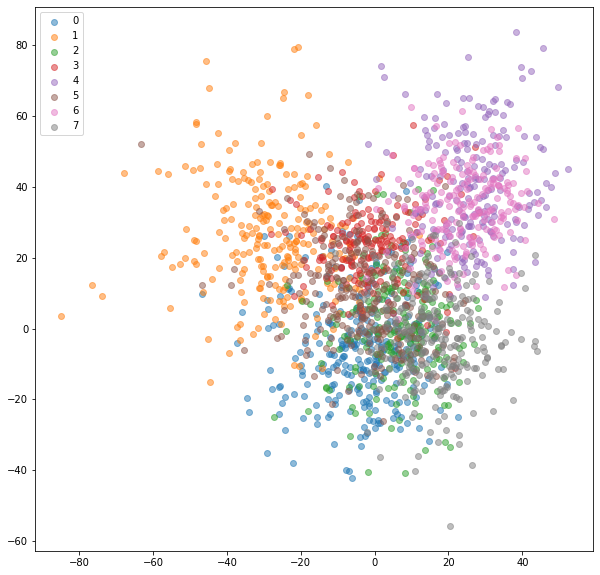

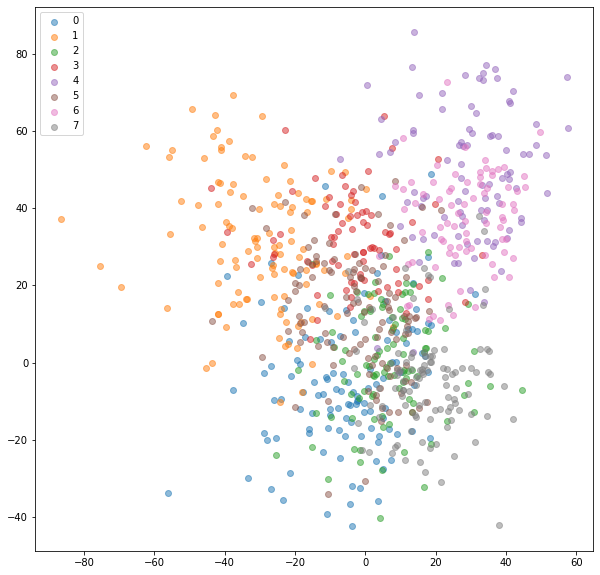

In [10]:
%matplotlib inline
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 8))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

/home/manelguz/miniconda3/envs/pytorch_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


score obtained equal to 0.8612143742255266


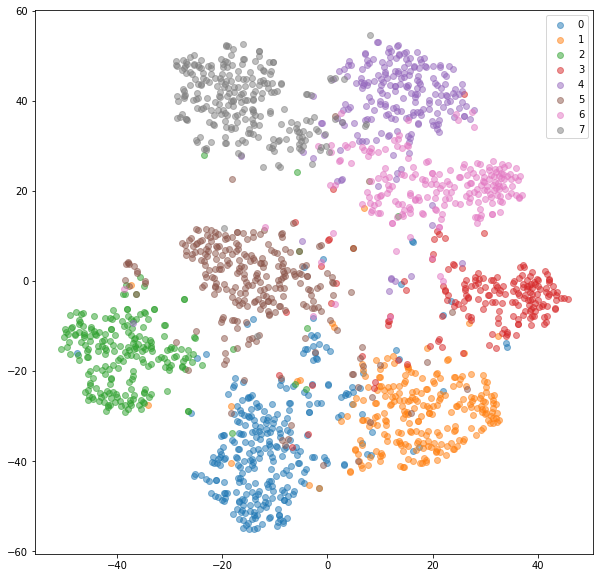

In [11]:
%matplotlib inline
#from plot_emb import plot_embeddings, extract_embeddings
import numpy as np
cuda = torch.cuda.is_available()
import matplotlib
import matplotlib.pyplot as plt

classes = ['0', '1', '2', '3', '4', '5', '6', '7']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
        ]

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(classes)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 8))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images.float()).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels


def fit_retrival(embeddings,labels,mode='knn'):
    if mode == 'knn':
        clf = neighbors.KNeighborsClassifier(n_neighbors=8)
        clf.fit(embeddings, labels)
    return clf
def predict_retrival(model,embeddings,labels):
    return model.predict(embeddings),model.score(embeddings,labels)
def plot_TSNE(embeddings):
    from sklearn.manifold import TSNE
    X_embedded = TSNE(n_components=2,
                 init='random').fit_transform(embeddings)
    return  X_embedded

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)

TSNE_embedding = plot_TSNE(train_embeddings_otl)
retrival_module = fit_retrival(train_embeddings_otl,train_labels_otl,mode='knn')

plot_embeddings(TSNE_embedding, train_labels_otl)


test_embeddings_otl, test_labels_otl = extract_embeddings(test_loader, model)
labels,score = predict_retrival(retrival_module,test_embeddings_otl, test_labels_otl)
print('score obtained equal to {}'.format(score))


In [12]:
def precision_recall_curve(X,Y,module):
    from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)
    from sklearn import preprocessing
    predictions = module.predict(X)
    y_score = module.predict_proba(X)
    precision = dict()
    clf = preprocessing.LabelBinarizer()
    clf.fit(Y)
    Y = clf.transform(Y)
    recall = dict()
    for i in range(8):
        precision[i], recall[i], _ = precision_recall_curve(Y[:, i],
                                                            y_score[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
        
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()



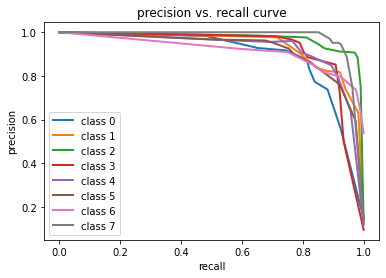

In [13]:
precision_recall_curve(test_embeddings_otl, test_labels_otl,retrival_module)